In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC,SVC
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['heart.csv']


# Import the data

In [2]:
data = pd.read_csv('../input/heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Descriptive Statistics
### Age

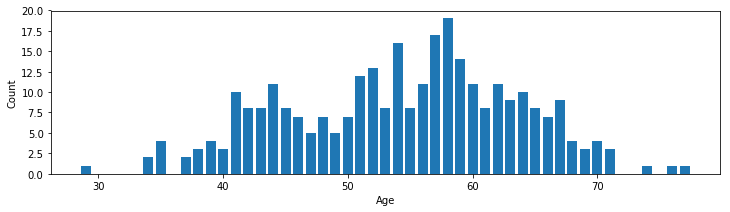

In [3]:
f, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.bar(data.age.value_counts().index, data.age.value_counts().values)
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

In [4]:
print('The minimum age in the dataset is {}, the maximum age is {} and the mean is {}'.format(np.min(data.age.values), np.max(data.age.values), np.mean(data.age.values)))


The minimum age in the dataset is 29, the maximum age is 77 and the mean is 54.366336633663366


### Sex
Sex (1 = male; 0 = female)

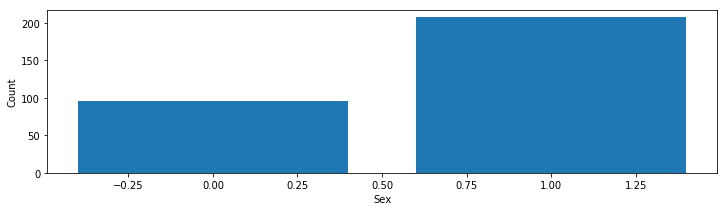

In [5]:
f, ax = plt.subplots(1, 1, figsize=(12, 3))
ax.bar(data.sex.value_counts().index, data.sex.value_counts().values)
plt.xlabel('Sex')
plt.ylabel('Count')
plt.show()

In [6]:
print('There are {} men in the dataset and {} women'.format(np.count_nonzero(data.sex.values== 1), np.count_nonzero(data.sex.values==0)))


There are 207 men in the dataset and 96 women


In [7]:
print('There are {} men with hearth disease (target == 1) and {} men "healthy"'.format(np.count_nonzero(data.sex.values & data.target.values), np.count_nonzero(data.sex.values & 1-data.target.values)))
print('There are {} women with hearth disease (target == 1) and {} women "healthy"'.format(np.count_nonzero(1-data.sex.values & data.target.values), np.count_nonzero(1-data.sex.values & 1-data.target.values)))


There are 93 men with hearth disease (target == 1) and 114 men "healthy"
There are 72 women with hearth disease (target == 1) and 24 women "healthy"


## Columns Features
1. Age (age in years)
2. Sex (1 = male; 0 = female)
3. CP (chest pain type)
4. TRESTBPS (resting blood pressure (in mm Hg on admission to the hospital))
5. CHOL (serum cholestoral in mg/dl)
6. FPS (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
7. RESTECH (resting electrocardiographic results)
8. THALACH (maximum heart rate achieved)
9. EXANG (exercise induced angina (1 = yes; 0 = no))
10. OLDPEAK (ST depression induced by exercise relative to rest)
11. SLOPE (the slope of the peak exercise ST segment)
12. CA (number of major vessels (0-3) colored by flourosopy)
13. THAL (3 = normal; 6 = fixed defect; 7 = reversable defect)
14. TARGET (1 or 0)

In [8]:
np.min(data.values[:,12])

0.0

In [9]:
#Let's see some of the people with target == 1
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [10]:
#Let's see some of the people with target == 0
data.tail()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0
302,57,0,1,130,236,0,0,174,0,0.0,1,1,2,0


## Dummy Sex Variable

In [11]:
dummy_sex = pd.get_dummies(data["sex"],prefix="sex")
dummy_sex.columns.values[0] = "Women"
dummy_sex.columns.values[1] = "Men"
dummy_sex.head()

,Women,Men
0,0,1
1,0,1
2,1,0
3,0,1
4,1,0


In [12]:
data = data.drop(["sex"],axis = 1)

In [13]:
data = pd.concat([dummy_sex,data],axis=1)

In [14]:
data.head()

,Women,Men,age,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,1,63,3,145,233,1,0,150,0,2.3,0,0,1,1
1,0,1,37,2,130,250,0,1,187,0,3.5,0,0,2,1
2,1,0,41,1,130,204,0,0,172,0,1.4,2,0,2,1
3,0,1,56,1,120,236,0,1,178,0,0.8,2,0,2,1
4,1,0,57,0,120,354,0,1,163,1,0.6,2,0,2,1


In order to have an idea on how the data can be classified, first some basic models are going to be run. 

## Separate the categorical data from the continuous

In [15]:
data_cat = data[["Women","Men","age","cp","fbs","restecg","exang","slope","ca","thal","target"]]
data_cat.head()

,Women,Men,age,cp,fbs,restecg,exang,slope,ca,thal,target
0,0,1,63,3,1,0,0,0,0,1,1
1,0,1,37,2,0,1,0,0,0,2,1
2,1,0,41,1,0,0,0,2,0,2,1
3,0,1,56,1,0,1,0,2,0,2,1
4,1,0,57,0,0,1,1,2,0,2,1


In [16]:
data_con = data[["trestbps","chol","thalach","oldpeak","target"]]
data_con.head()

,trestbps,chol,thalach,oldpeak,target
0,145,233,150,2.3,1
1,130,250,187,3.5,1
2,130,204,172,1.4,1
3,120,236,178,0.8,1
4,120,354,163,0.6,1


## First Classifier

Linear classifier only taking the sex.

In [17]:
X = data.values[:,0:2].astype(float)
Y = data.values[:,14].astype(int)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.50)

0.6118421052631579


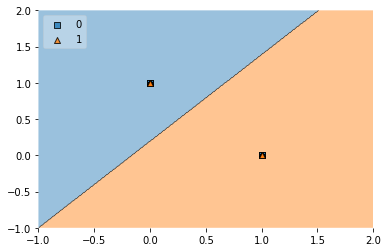

In [19]:
clasificador = LinearSVC(C=0.0001)
clasificador.fit(X_train, y_train)
print(clasificador.score(X_test, y_test))
plot_decision_regions(X_test, y_test, clf=clasificador, legend=2)

**This is clearly not a good classifier**

## Second Classifier

Using only the continous variables.

In [20]:
X = data_con.values[:,0:-1].astype(float)
Y = data.values[:,-1].astype(int)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.50)

In [22]:
clasificador = LinearSVC(C=0.0001)
clasificador.fit(X_train, y_train)
print(clasificador.score(X_test, y_test))


0.6710526315789473


**This is definetely better but there is still room for improvement**

## Third Classifier
Using only the categorical variables.

In [23]:
X = data_cat.values[:,0:-1].astype(float)
Y = data.values[:,-1].astype(int)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.50)

In [25]:
clasificador = LinearSVC(C=0.0001)
clasificador.fit(X_train, y_train)
print(clasificador.score(X_test, y_test))

0.5


## Fourth Classifier
With all of the features

In [26]:
X = data.values[:,0:-1].astype(float)
Y = data.values[:,-1].astype(int)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.50)

In [28]:
clasificador = LinearSVC(C=0.0001)
clasificador.fit(X_train, y_train)
print(clasificador.score(X_test, y_test))

0.6644736842105263


## Let's run more models at once

Models for the continuous data only

In [29]:
X = data_con.values[:,0:-1].astype(float)
Y = data_con.values[:,-1].astype(int)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.50)

In [31]:
std = StandardScaler()
pca = PCA(n_components=5)
clas = LinearSVC(C=200.0, max_iter=10000, tol=0.01)
clas2 = SVC(C=200.0, kernel='rbf')
pipe = Pipeline([('std', std), ('pca', pca), ('clas', clas)])
param_grid = {'pca__n_components': [4, 3, 2],
              'clas__C': [0.1, 1.0, 10.0, 100.0, 1000.0],
              'clas': [clas, clas2]}
search = GridSearchCV(pipe, param_grid, n_jobs=-1, verbose=10)

In [32]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1881s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1082s.) Setting bat

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clas', LinearSVC(C=1000.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.01,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'pca__n_components': [4, 3, 2], 'clas__C': [0.1, 1.0, 10.0, 100.0, 1000.0], 'clas': [LinearSVC(C=1000.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.01,
  ...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)]},
       pr

In [33]:
search.best_estimator_.score(X_test, y_test)

0.743421052631579

In [34]:
search.best_params_ # Best parameters for the continuous data

{'clas': LinearSVC(C=1000.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=10000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.01,
      verbose=0), 'clas__C': 1000.0, 'pca__n_components': 2}

## Let's run more models at once

Models for all of the data

In [35]:
X = data.values[:,0:-1].astype(float)
Y = data.values[:,-1].astype(int)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.50)

In [37]:
search.fit(X_train, y_train)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0149s.) Setting batch_size=26.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0149s.) Setting batch_size=698.


Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    1.5s finished
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('std', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clas', LinearSVC(C=100.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.01,
     verbose=0))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'pca__n_components': [4, 3, 2], 'clas__C': [0.1, 1.0, 10.0, 100.0, 1000.0], 'clas': [LinearSVC(C=100.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=10000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.01,
   ...f', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)]},
       pre

In [38]:
search.best_estimator_.score(X_test, y_test)

0.8289473684210527

In [39]:
search.best_params_ # Best parameters for the continuous data

{'clas': LinearSVC(C=100.0, class_weight=None, dual=True, fit_intercept=True,
      intercept_scaling=1, loss='squared_hinge', max_iter=10000,
      multi_class='ovr', penalty='l2', random_state=None, tol=0.01,
      verbose=0), 'clas__C': 100.0, 'pca__n_components': 3}

In [40]:
pd.DataFrame(search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py

,params,mean_test_score,std_test_score
0,"{'clas': LinearSVC(C=100.0, class_weight=None,...",0.821192,0.003372
1,"{'clas': LinearSVC(C=100.0, class_weight=None,...",0.827815,0.031584
2,"{'clas': LinearSVC(C=100.0, class_weight=None,...",0.821192,0.024918
3,"{'clas': LinearSVC(C=100.0, class_weight=None,...",0.821192,0.003372
4,"{'clas': LinearSVC(C=100.0, class_weight=None,...",0.827815,0.031584
5,"{'clas': LinearSVC(C=100.0, class_weight=None,...",0.821192,0.024918
6,"{'clas': LinearSVC(C=100.0, class_weight=None,...",0.821192,0.003372
7,"{'clas': LinearSVC(C=100.0, class_weight=None,...",0.827815,0.031584
8,"{'clas': LinearSVC(C=100.0, class_weight=None,...",0.827815,0.034472
9,"{'clas': LinearSVC(C=100.0, class_weight=None,...",0.821192,0.003372
